# MobileNet V3 Experiments

- **Main papaer (preprint):** https://arxiv.org/pdf/1905.02244v5.pdf
- **Implementaion examples:** https://www.paperswithcode.com/paper/searching-for-mobilenetv3

This notebook is based on https://github.com/xiaolai-sqlai/mobilenetv3/blob/master/mobilenetv3.py

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from pyraul.tools.dumping import print_torch_tensor, dump_weights, gen_cpp_dtVec, size

## Main blocks

### Hard swish activation function

\begin{align}
\mathrm{hswish}(x) = \frac{x}{6} \mathrm{ReLU6}(x+3),
\end{align}

where 
\begin{align}
\mathrm{ReLU6}(x) = \min(\max(x, 0), 6).
\end{align}

In [7]:
# inplace=True means that x will be overwritten which reduces memory usage
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out

Note: orinal swish function looks like $\mathrm{swish}(x) = x \sigma(x)$.

### Hard sigmoid

\begin{align}
\mathrm{hsigmoid}(x) = \frac{1}{6} \mathrm{ReLU6}(x+3),
\end{align}

In [8]:
# inplace=True means that x will be overwritten which reduces memory usage
class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out

###  Squeeze-and-Excite Block aka SE Block

Main article: https://arxiv.org/pdf/1709.01507.pdf

This block is aimed to improve the quality of representations produced by a network by explicitly modelling the interdependencies between the channels of its convolutional features.

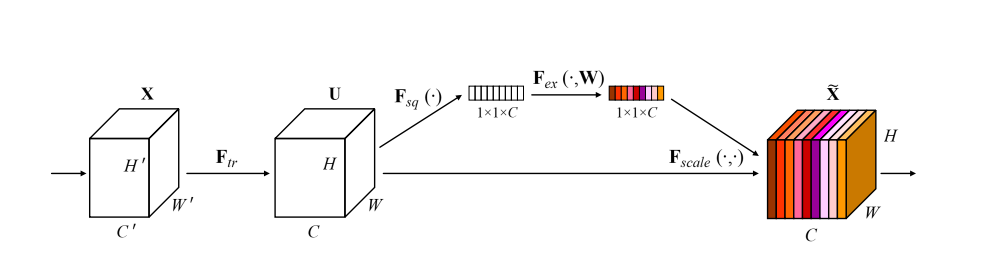

**Idea** 

A classic convolutional network weights each of its channels equally when creating the output feature maps. It can be impoved by weighting each channel adaptively. To do this the feature maps are squeezed to a single numeric value. This results in a vector of size $n$, where n is equal to the number of convolutional channels. Afterwards, it is fed through a two-layer neural network, which outputs a vector of the same size. These $n$ values can now be used as weights on the original features maps, scaling each channel based on its importance.

Read more: https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7

In [9]:
class SeModule(nn.Module):
    def __init__(self, in_channels, reduction=4, bias=False):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Output 1x1xC (parameters adapts automatically)
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, stride=1, padding=0, bias=bias), # FC
            nn.BatchNorm2d(in_channels // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, stride=1, padding=0, bias=bias), # FC
            nn.BatchNorm2d(in_channels),
            hsigmoid(),
        )

    def forward(self, x):
        # Important: here we weight original features x using weights self.se(x)
        return x * self.se(x)

**None 1:** Reduction value = 4 (1/4 of channels) because the authors of the article found that doing so increases the accuracy, at the modest increase of number of
parameters, and no discernible latency cost.

**Note 2:** FC layer can be converted to a CONV layer.

### Basic MobileNet V3 block aka bottleneck aka bneck

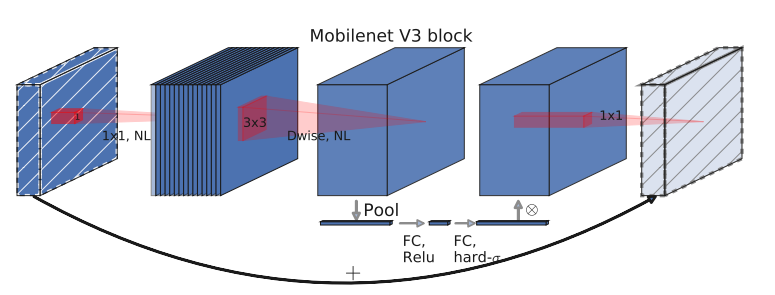

Briefly, it is  MobileNetV2 block (Inverted Residual and Linear Bottleneck) + Squeeze-and-Excite block.

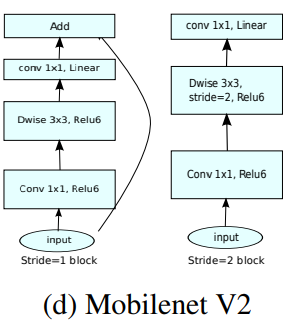

In [10]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, 
                 kernel_size, 
                 in_channels, 
                 expand_channels, 
                 out_channels, 
                 nolinear, 
                 semodule, 
                 stride,
                 bias=False
                ):
        super().__init__()
        self.stride = stride
        self.se = semodule

        # 1x1, NL
        self.conv1 = nn.Conv2d(in_channels, expand_channels, kernel_size=1, stride=1, padding=0, bias=bias)
        self.bn1 = nn.BatchNorm2d(expand_channels)
        self.nolinear1 = nolinear
        
        # Dwise
        self.conv2 = nn.Conv2d(expand_channels, expand_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_channels, bias=bias)
        self.bn2 = nn.BatchNorm2d(expand_channels)
        self.nolinear2 = nolinear
        
        # Linear
        self.conv3 = nn.Conv2d(expand_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # For stride=2 no shorcut
        self.shortcut = nn.Sequential()
        
        # For stride=1 blocks
        if stride == 1 and in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=bias),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # 1x1, NL
        out = self.nolinear1(self.bn1(self.conv1(x)))
        # Dwise
        out = self.nolinear2(self.bn2(self.conv2(out)))
        # Lineaer
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        shortcut = self.shortcut(x)

        out = out + shortcut if self.stride==1 else out
        return out

## Architectures
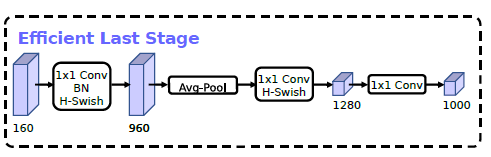

Last stage of MobileNet V3

### Large MobileNet V3
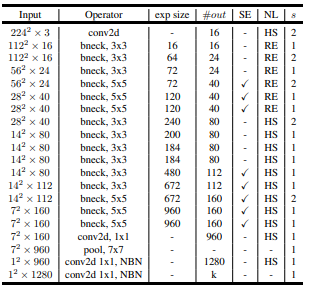
- exp size denotes expand size
- SE denotes whether there is a Squeeze-And-Excite in that block
- NL denotes the type of nonlinearity used: HS denotes h-swish and RE denotes ReLU
- NBN denotes no batch normalization
- s denotes stride

In [6]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 16, 16, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        
        self.linear3 = nn.Linear(960, 1280)
        self.hs3 = hswish()
        
        self.linear4 = nn.Linear(1280, num_classes)
        
        # Initialization of some layers
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        #conv2d
        out = self.hs1(self.bn1(self.conv1(x)))
        #bneck stack
        out = self.bneck(out)
        #conv2d
        out = self.hs2(self.bn2(self.conv2(out)))
        #pool
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        #conv2d, NBN
        out = self.hs3(self.linear3(out))
        #conv2d, NBN
        out = self.linear4(out)
        return out

### Small MobileNet V3
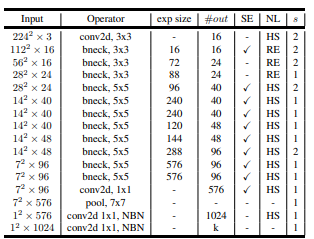
- exp size denotes expand size
- SE denotes whether there is a Squeeze-And-Excite in that block
- NL denotes the type of nonlinearity used: HS denotes h-swish and RE denotes ReLU
- NBN denotes no batch normalization
- s denotes stride

In [11]:
class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=1000, bias=False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(16)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 16, 16, 16, nn.ReLU(inplace=True), SeModule(16, bias=bias), 2, bias=bias),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2, bias=bias),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1, bias=bias),
            Block(5, 24, 96, 40, hswish(), SeModule(40, bias=bias), 2, bias=bias),
            Block(5, 40, 240, 40, hswish(), SeModule(40, bias=bias), 1, bias=bias),
            Block(5, 40, 240, 40, hswish(), SeModule(40, bias=bias), 1, bias=bias),
            Block(5, 40, 120, 48, hswish(), SeModule(48, bias=bias), 1, bias=bias),
            Block(5, 48, 144, 48, hswish(), SeModule(48, bias=bias), 1, bias=bias),
            Block(5, 48, 288, 96, hswish(), SeModule(96, bias=bias), 2, bias=bias),
            Block(5, 96, 576, 96, hswish(), SeModule(96, bias=bias), 1, bias=bias),
            Block(5, 96, 576, 96, hswish(), SeModule(96, bias=bias), 1, bias=bias),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=bias)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        
        self.linear3 = nn.Linear(576, 1024)
        self.hs3 = hswish()
        
        self.linear4 = nn.Linear(1024, num_classes)
        
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        #conv2d
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.hs1(out)

        #bneck stack
        out = self.bneck(out)
        #conv2d
        out = self.hs2(self.bn2(self.conv2(out)))
        #pool
        out = F.avg_pool2d(out, 7)
        batch_size = out.size(0)
#         batch_size = 50
        out = out.view(batch_size, -1)
        #conv2d, NBN
        out = self.hs3(self.linear3(out))
        #conv2d, NBN
        out = self.linear4(out)
        return out

## Training

### Device choose

We will use GPU for training

In [ ]:
!gpustat -cpu

In [ ]:
cuda_device = "cuda"
device = cuda_device if torch.cuda.is_available() else "cpu"

### Seed

In [ ]:
from pyraul.tools.seed import set_seed
set_seed(0)

### Classifier model on MobileNet V3

In [13]:
from enum import Enum

class ClassifierType(Enum):
    Small=0
    Large=1
    
class Classifier(nn.Module):
    def __init__(self, model: ClassifierType, num_classes, bias=False):
        super().__init__()
        self.mobilenetv3 = None
        if model == ClassifierType.Small:
            self.mobilenetv3 = MobileNetV3_Small(num_classes, bias=bias)
        if model == ClassifierType.Large:
            self.mobilenetv3 = MobileNetV3_Large(num_classes, bias=bias)
        assert self.mobilenetv3
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.mobilenetv3(x)
        x = self.softmax(x)
        return x

### Small MobileNet V3 training

In [ ]:
from pyraul.tools.dataset import Dataset
from pyraul.tools.dumping import save_checkpoint
from pyraul.pipeline.train_step import train_step
from pyraul.pipeline.inference import accuracy
import torchvision.transforms as transforms


def run_training(optimizer_factory, model_type, batch_size = 64, epochs = 10, multigpu: bool = False):
    ds = Dataset("CIFAR10", 
                 batch_size, 
                 train_transform = [transforms.Resize(224, interpolation=0), transforms.ToTensor()],
                 test_transform = [transforms.Resize(224, interpolation=0), transforms.ToTensor()]
                )

    model = Classifier(model_type, 10)
    if multigpu:
        model = nn.DataParallel(model)
    model.to(device)
    
    optimizer = optimizer_factory(model)

    criterion = nn.NLLLoss()
    
    history_acc = []
    history_train = []

    def get_acc(model):
        acc_val = accuracy(model, ds.test_loader, device=device)
        print(f"Accuracy: {acc_val:.6f}")
        return acc_val

    get_acc(model)

    for epoch in range(1, epochs+1):
        print(f"Epoch: {epoch:03}/{epochs:03}")
        train_val = train_step(ds.train_loader, 
                               model, 
                               criterion,
                               optimizer, 
                               device, 
                               print_freq=100
                              )
        history_train.append(train_val)
        acc = get_acc(model)
        history_acc.append(acc)
        save_checkpoint({"epoch": epoch, "acc": acc, "state_dict": model.state_dict()})
    return history_acc, history_train

In [ ]:
lr = 0.05
batch_size = 128
epochs = 10
optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=lr)
results = run_training(optimizer, ClassifierType.Small, batch_size, epochs, multigpu=False)
save_checkpoint(results, filename="results.pth.tar")

In [ ]:
torch.cuda.empty_cache()

## Report

In [ ]:
import torch

data={}
sizes=("Small", "Large")
batch_sizes=(16,32,64,128)
optimizers=("sgd", "sgd_momentum", "sgd_momentum_nesterov", "adamax", "adam", "adagrad", "adadelta")
for size in sizes:
    data_size={}
    for bs in batch_sizes:
        data_bs={}
        for opt in optimizers:
            history_acc, history_train = torch.load(f"./bs.{bs}_opt.{opt}_t.ClassifierType.{size}_e.50_results.pth.tar")
            data_bs[opt] = {
                              "loss": [x.loss_avg for x in history_train],
                              "acc": history_acc
                           }
        data_size[bs]=data_bs
    data[size.lower()] = data_size

In [ ]:
plt.title('MobileNetV3 Small, SGD, different batch sizes')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epoch')
for bs in batch_sizes:
    plt.plot(data["small"][bs]["sgd"]["loss"], label=str(bs))
plt.legend(loc='upper right')
plt.savefig("mobilenetv3_small_sgd_loss_bs.png")

In [ ]:
plt.title('MobileNetV3 Small, Adam, different batch sizes')
plt.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
for bs in batch_sizes:
    plt.plot(data["small"][bs]["adam"]["acc"], label=str(bs))
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_adam_acc_bs.png")

In [ ]:
for size in sizes:
    for bs in batch_sizes:
        plt.title(f'MobileNetV3 {size}, batch size {bs}, different optimizers')
        plt.grid(True)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        for opt in optimizers:
            plt.plot(data[size.lower()][bs][opt]["loss"], label=str(opt))
        plt.legend(loc='upper right')
        plt.savefig(f"mobilenetv3_{size.lower()}_bs{bs}_loss_opt.png")
        plt.show()
        plt.clf()

In [ ]:
for size in sizes:
    for bs in batch_sizes:
        plt.title(f'MobileNetV3 {size}, batch size {bs}, different optimizers')
        plt.grid(True)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        for opt in optimizers:
            plt.plot(data[size.lower()][bs][opt]["acc"], label=str(opt))
        plt.legend(loc='lower right')
        plt.savefig(f"mobilenetv3_{size.lower()}_bs{bs}_acc_opt.png")
        plt.show()
        plt.clf()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()

plt.grid(True)
plt.title('MobileNetV3 Small, Adam, batch size 16')

ax2 = ax1.twinx()
ax1.plot(data["small"][16]["adam"]["acc"], 'g-')
ax2.plot(data["small"][16]["adam"]["loss"], 'r-')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test accuracy', color='g')
ax2.set_ylabel('Train Loss avg', color='r')

plt.savefig("mobilenetv3_small_bs16_adam_acc_loss.png")

## Dumping for C++ tests

### SE block (test SeBlockBuilding)

In [ ]:
se = SeModule(8, bias=True)
print(se)
print(size(se))

### Bottleneck Block (test BottleneckBlockBuildingNoSE)

In [ ]:
bneck = Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2, bias=True)
print(bneck)
print(size(bneck))

### Bottleneck Block (test BottleneckBlockBuildingSE)

In [ ]:
bneck = Block(5, 40, 120, 48, hswish(), SeModule(48, bias=True), 1, bias=True)
print(bneck)

### MobileNetV3 Small (test OutputBlockBuilding)

In [10]:
class OutputBlock(nn.Module):
    def __init__(self, num_classes, bias=False):
        super().__init__()
        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=bias)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()

        self.linear3 = nn.Linear(576, 1024)
        self.hs3 = hswish()

        self.linear4 = nn.Linear(1024, num_classes)

    def forward(self, out):
        #conv2d
        out = self.hs2(self.bn2(self.conv2(out)))
        #pool
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        #conv2d, NBN
        out = self.hs3(self.linear3(out))
        #conv2d, NBN
        out = self.linear4(out)

output = OutputBlock(10, True)
print(output)
print(size(output))

OutputBlock(
  (conv2): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hs2): hswish()
  (linear3): Linear(in_features=576, out_features=1024, bias=True)
  (hs3): hswish()
  (linear4): Linear(in_features=1024, out_features=10, bias=True)
)
658122


### MobileNetV3 Small (test InputBlockBuilding)

In [ ]:
class InputBlock(nn.Module):
    def __init__(self, bias=False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(16)
        self.hs1 = hswish()

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))

in_block = InputBlock(True)
print(in_block)
print(size(in_block))

### MobileNetV3 Small (test SmallNetBuilding)

In [ ]:
small_net = MobileNetV3_Small(num_classes=10, bias=True)
# print(small_net)
print(size(small_net))

### MobileNetV3 Small (test SeBlockInference)

In [ ]:
import os
import numpy as np
from pyraul.tools.dumping import dump_weights, gen_cpp_dtVec 
from pyraul.tools.seed import set_seed

config = {
    "seed": 0,
    "batch_size": 2,
    "size": 4,
    "bias": True
}

set_seed(config["seed"])

se = SeModule(config["size"], bias=config["bias"])
se.eval()
print(se)

dump_weights(se, "init.txt", flatten=True)

# for name, param in se.named_parameters():
#         if param.requires_grad:
#             print(name, param.shape)

tensor_in = torch.from_numpy(np.ones((config["batch_size"], config["size"], 1, 1), dtype=np.float32)*5)
tensor_out = se(tensor_in)
assert tensor_in.shape==tensor_out.shape
print(gen_cpp_dtVec(tensor_out.data.flatten(), "golden_tensor_our"))

### MobileNetV3 Small (test BottleneckBlockInference)

In [ ]:
import os
import numpy as np
from pyraul.tools.dumping import dump_weights, gen_cpp_dtVec, size 
from pyraul.tools.seed import set_seed

config = {
    "seed": 0,
    "image_size": 2,
    "kernel_size": 5,
    "in_channels": 10,
    "expand_channels": 15,
    "out_channels": 4,
    "stride": 1,
    "batch_size": 2,
    "bias": True
}

set_seed(config["seed"])

bneck = Block(config["kernel_size"], 
              config["in_channels"], 
              config["expand_channels"],
              config["out_channels"], 
              hswish(), 
              SeModule(config["out_channels"], bias=True),
              config["stride"], 
              bias=True)
print(bneck)
bneck.eval()

# dump_weights(bneck, "init.txt", flatten=True)

# for name, param in bneck.named_parameters():
#         if param.requires_grad:
#             print(name, param.shape)


tensor_in = torch.from_numpy(np.ones((config["batch_size"],  config["in_channels"], config["image_size"], config["image_size"]), dtype=np.float32)*5)
tensor_out = bneck(tensor_in)
print(gen_cpp_dtVec(tensor_out.data.flatten(), "golden_tensor_out"))

### Infernce Step

In [44]:
import os
import numpy as np
from pyraul.tools.dumping import dump_weights, gen_cpp_dtVec 
from pyraul.tools.seed import set_seed

config = {
    "seed": 0,
    "classes": 10,
    "bias": True
}

set_seed(config["seed"])

small_net = MobileNetV3_Small(num_classes=config["classes"], bias=config["bias"])
small_net.eval()

dump_weights(small_net, "init.txt", mode=DumpMode.flatten_transpose)
dump_weights(small_net, "init.txt", mode=DumpMode.transpose_flatten, filter="linear")

tensor_in = torch.from_numpy(np.ones((1, 3, 224, 224), dtype=np.float32)*5)
tensor_out = small_net(tensor_in)
print_torch_tensor("out", tensor_out)
print(gen_cpp_dtVec(tensor_out.data.flatten(), "golden_tensor_out"))

out (torch.Size([1, 10])):
['5.78190829e-09', '3.26521632e-09', '-6.43653353e-10', '2.14028972e-09', '-2.90977842e-09', '-7.53793306e-10', '-3.28354322e-09', '3.19889781e-09', '-1.24177568e-09', '-2.47577181e-10']
const raul::dtVec golden_tensor_out{5.78190828548486e-09_dt, 3.2652163195479034e-09_dt, -6.43653352838669e-10_dt, 2.140289723229216e-09_dt, -2.9097784182141595e-09_dt, -7.537933055523638e-10_dt, -3.2835432151046007e-09_dt, 3.1988978133057344e-09_dt, -1.241775682281343e-09_dt, -2.4757718097845327e-10_dt};


In [42]:
import re

def get_param_naem(name):
    if name == "weight":
        return "Weights"
    elif name == "running_mean":
        return "MeanEval"
    elif name == "running_var":
        return "VarianceEval"
    else:
        return "Biases"

def print_pytorch_name_map(model, prefix=""):
    def apply_for(lst, se_cnt=0):
        for name, param in  lst:
                    pattern = re.compile(f"{prefix}(.*)")
                    name = pattern.match(name).groups()[0]
                    size = param.data.flatten().shape[0]
                    if "bneck" in name:
                        if "shortcut" in name:
                            pattern = re.compile(f"bneck\.(\d*)\.shortcut\.(\d*)\.(.*)")
                            found = pattern.match(name).groups()
                            p = get_param_naem(found[2])
                            t = "conv3" if int(found[1]) == 0 else "bn3"
                            print(f"{{\"block{found[0]}::{t}::{p}\", {{\"{name}\", {size}}}}},")
                        elif "se" not in name:
                            pattern = re.compile(f"bneck\.(\d*)\.(.+?)(\d*)\.(.*)")
                            found = pattern.match(name).groups()
                            p = get_param_naem(found[3])
                            n = int(found[2])
                            print(f"{{\"block{found[0]}::{found[1]}{n-1}::{p}\", {{\"{name}\", {size}}}}},")
                        else:
                            pattern = re.compile(f"bneck\.(\d*)\.se\.se\.(\d*)\.(.*)")
                            found = pattern.match(name).groups()
                            t = "unknown"
                            if int(found[1]) == 1:
                                t = "conv1"  
                            elif int(found[1]) == 2:
                                t = "bn1"
                            elif int(found[1]) == 4:
                                t="conv2"
                            elif int(found[1]) == 5:
                                t="bn2"
                            p = get_param_naem(found[2])
                            print(f"{{\"se{se_cnt}::{t}::{p}\", {{\"{name}\", {size}}}}},")
                            if int(found[1]) == 5 and (p=="Biases" or p=="VarianceEval"):
                                se_cnt +=1
                    elif "linear" in name:
                        pattern = re.compile(f"linear(\d+)\.(.*)")
                        found = pattern.match(name).groups()
                        p = get_param_naem(found[1])
                        print(f"{{\"output::fc{int(found[0])-3}::{p}\", {{\"{name}\", {size}}}}},")
                    else:
                        pattern = re.compile(f"(.*)\d+\.(.*)")
                        found = pattern.match(name).groups()
                        t = "unknown"
                        if "1" in name:
                            t="input"
                        elif "2" in name:
                            t="output"
                        p = get_param_naem(found[1])
                        print(f"{{\"{t}::{found[0]}0::{p}\", {{\"{name}\", {size}}}}},")
    print("{")
    param_list = [(name, param) for (name, param) in model.named_parameters() if param.requires_grad]
    apply_for(param_list)
    state_list = [(name, param) for (name, param) in model.state_dict().items() if "running" in name]
    apply_for(state_list)
    print("}")

### CIFAR Train

In [ ]:
from pyraul.tools.seed import set_seed
import torchvision.transforms as transforms
from pyraul.tools.dataset import Dataset
from pyraul.pipeline import accuracy
from pyraul.pipeline.train_step import train_step

config = {
    "seed": 0,
    "classes": 10,
    "bias": True,
    "batch_size": 50,
    "device": "cuda",
#     "device": "cpu",
    "epochs": 20,
    "sgd": {"lr": 0.05}
}

set_seed(config["seed"])

device = torch.device(config["device"])
model = Classifier(ClassifierType.Small, num_classes=config["classes"], bias=config["bias"])
# model = model.double().to(device)
model = model.to(device)

# dump_weights(model, "init.txt")

ds= Dataset("CIFAR10",
            train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
#             train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor(), lambda x: x.double()],
#             test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor(), lambda x: x.double()],
            **config)
optimizer = torch.optim.SGD(model.parameters(), lr=config["sgd"]["lr"])
criterion = nn.NLLLoss(reduction="mean")

accuracy_before = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
)

print(accuracy_before)

loss, _, _ = train_step(
                    ds.train_loader, 
                    model,
                    criterion,
                    optimizer,
                    device,
                    print_freq=100,
                    verbose=True,
                    loss_history=True
                )

accuracy_after = accuracy(
    model=model,
    dataloader=ds.test_loader,
    **config,
)
print(accuracy_after)
# CPU
# 10.0
# Step    0/1000	Loss: 2.302577 (2.302577)	Time.step: 0.912 (0.912)	Time.load: 0.036 (0.036)
# Step  100/1000	Loss: 2.298537 (2.302040)	Time.step: 0.911 (0.907)	Time.load: 0.028 (0.031)
# Step  200/1000	Loss: 2.242681 (2.295321)	Time.step: 0.951 (0.914)	Time.load: 0.029 (0.031)
#
# GPU
# 10.0
# Step    0/1000	Loss: 2.302577 (2.302577)	Time.step: 0.086 (0.086)	Time.load: 0.023 (0.023)
# Step  100/1000	Loss: 2.298564 (2.302037)	Time.step: 0.085 (0.084)	Time.load: 0.026 (0.027)
# Step  200/1000	Loss: 2.261648 (2.294991)	Time.step: 0.083 (0.084)	Time.load: 0.027 (0.027)
#
# GPU (double)
# 14.01
# Step    0/1000	Loss: 2.302577 (2.302577)	Time.step: 0.233 (0.233)	Time.load: 0.077 (0.077)
# Step  100/1000	Loss: 2.298534 (2.302045)	Time.step: 0.261 (0.245)	Time.load: 0.104 (0.090)
# Step  200/1000	Loss: 2.254554 (2.295272)	Time.step: 0.219 (0.246)	Time.load: 0.062 (0.090)
# Step  300/1000	Loss: 2.085075 (2.259762)	Time.step: 0.220 (0.247)	Time.load: 0.063 (0.091)
# Step  400/1000	Loss: 2.142479 (2.203500)	Time.step: 0.255 (0.249)	Time.load: 0.099 (0.093)
# Step  500/1000	Loss: 1.933111 (2.149139)	Time.step: 0.247 (0.250)	Time.load: 0.090 (0.093)
# Step  600/1000	Loss: 1.804388 (2.110213)	Time.step: 0.239 (0.251)	Time.load: 0.082 (0.095)
# Step  700/1000	Loss: 1.833483 (2.075947)	Time.step: 0.224 (0.252)	Time.load: 0.067 (0.095)

In [ ]:
print(
    "const raul::dtVec idealLosses{", 
    ", ".join([f"{x}_dt" for x in loss.history[::100]]),
    "};")

### Up to 80% accuracy

In [ ]:
from pyraul.tools.seed import set_seed
import torchvision.transforms as transforms
from pyraul.tools.dataset import Dataset
from pyraul.pipeline import accuracy
from pyraul.pipeline.train_step import train_step
from pyraul.tools.dumping import save_checkpoint

config = {
    "seed": 0,
    "classes": 10,
    "bias": True,
    "batch_size": 50,
    "device": "cuda",
#     "device": "cpu",
    "epochs": 30,
    "sgd": {"lr": 0.05}
}

set_seed(config["seed"])

device = torch.device(config["device"])
model = Classifier(ClassifierType.Small, num_classes=config["classes"], bias=config["bias"])
# model = model.double().to(device)
model = model.to(device)

# dump_weights(model, "init.txt")

ds= Dataset("CIFAR10",
            train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
#             train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor(), lambda x: x.double()],
#             test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor(), lambda x: x.double()],
            **config)
#optimizer = torch.optim.SGD(model.parameters(), lr=config["sgd"]["lr"])
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss(reduction="mean")

accuracy_before = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
)

print(accuracy_before)

acc_history=[accuracy_before]
loss_history=[]

epochs = config["epochs"]
for epoch in range(1, epochs+1):
        print(f"Epoch: {epoch:03}/{epochs:03}")
        loss, _, _ = train_step(
                            ds.train_loader, 
                            model,
                            criterion,
                            optimizer,
                            device,
                            print_freq=100,
                            verbose=True,
                            loss_history=True
                        )

        loss_history += loss.history
        
        accuracy_after = accuracy(
            model=model,
            dataloader=ds.test_loader,
            **config,
        )
        print(accuracy_after)
        acc_history.append(accuracy_after)
        
        save_checkpoint({"epoch": epoch,
                         "acc": accuracy_after, 
                         "acc_history": acc_history,
                         "loss_history": loss_history,
                         "model_state_dict": model.state_dict(),
                         "optimizer_state_dict": optimizer.state_dict()
                        }, filename=f"checkpoint_{epoch}")

In [45]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
state = torch.load("checkpoint_20")
model.load_state_dict(state["model_state_dict"])
# dump_weights(model, "80.43.txt", mode=DumpMode.flatten_transpose)
# dump_weights(model, "80.43.txt", mode=DumpMode.transpose_flatten, filter="linear")
# print_pytorch_name_map(model, "mobilenetv3.")

<All keys matched successfully>

In [18]:
from pyraul.tools.seed import set_seed
import torchvision.transforms as transforms
from pyraul.tools.dataset import Dataset
from pyraul.pipeline import accuracy
from pyraul.pipeline.train_step import train_step
from pyraul.tools.dumping import save_checkpoint

config = {
    "seed": 0,
    "classes": 10,
    "bias": True,
    "batch_size": 64,
    "device": "cuda",
#     "device": "cpu",
    "sgd": {"lr": 0.05}
}

set_seed(config["seed"])

device = torch.device(config["device"])
model = Classifier(ClassifierType.Small, num_classes=config["classes"], bias=config["bias"])
model = model.to(device)

import torch
from pyraul.tools.dumping import dump_weights, DumpMode
state = torch.load("checkpoint_20")
model.load_state_dict(state["model_state_dict"])

ds= Dataset("CIFAR10",
            train_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            test_transform=[transforms.Resize(224, interpolation=0), transforms.ToTensor()],
            **config)
optimizer = torch.optim.SGD(model.parameters(), lr=config["sgd"]["lr"])
# optimizer = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss(reduction="mean")

accuracy_before = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
)
print(accuracy_before)

acc_history = []

for i in range(10):
    loss, _, _ = train_step(
                        ds.train_loader, 
                        model,
                        criterion,
                        optimizer,
                        device,
                        print_freq=100,
                        verbose=True,
                        loss_history=True
                    )

    accuracy_after = accuracy(
        model=model,
        dataloader=ds.test_loader,
        **config,
    )
    print(accuracy_after)
    
    acc_history.append(accuracy_after)

INFO: Loading CIFAR10 dataset...


Files already downloaded and verified
Files already downloaded and verified
80.4286858974359
Step   0/781	Loss: 0.122874 (0.122874)	Time.step: 0.106 (0.106)	Time.load: 0.031 (0.031)
Step 100/781	Loss: 0.053871 (0.110218)	Time.step: 0.093 (0.102)	Time.load: 0.033 (0.040)
Step 200/781	Loss: 0.039651 (0.090752)	Time.step: 0.096 (0.101)	Time.load: 0.034 (0.039)
Step 300/781	Loss: 0.054840 (0.083154)	Time.step: 0.093 (0.101)	Time.load: 0.033 (0.039)
Step 400/781	Loss: 0.013874 (0.079545)	Time.step: 0.094 (0.101)	Time.load: 0.033 (0.039)
Step 500/781	Loss: 0.047634 (0.072068)	Time.step: 0.089 (0.100)	Time.load: 0.032 (0.039)
Step 600/781	Loss: 0.058374 (0.066112)	Time.step: 0.098 (0.100)	Time.load: 0.033 (0.039)
Step 700/781	Loss: 0.033940 (0.060493)	Time.step: 0.091 (0.100)	Time.load: 0.033 (0.039)
81.87099358974359
Step   0/781	Loss: 0.010949 (0.010949)	Time.step: 0.107 (0.107)	Time.load: 0.033 (0.033)
Step 100/781	Loss: 0.023175 (0.021207)	Time.step: 0.096 (0.100)	Time.load: 0.033 (0.039)

### Report 

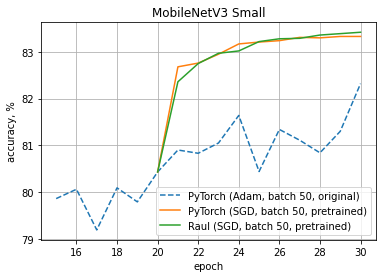

In [42]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
import matplotlib.pyplot as plt
%matplotlib inline


state = torch.load("checkpoint_30")
pytorch_acc_history = state["acc_history"]

pytorch_50_sgd_acc_history = [80.43] + acc_history
raul_50_sgd_acc_history= [
80.43,
82.36,
82.75,
82.97,
83.02,
83.22,
83.28,
83.29,
83.36,
83.39,
83.42
]

plt.title('MobileNetV3 Small')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
plt.plot(range(15,31),pytorch_acc_history[15:31], '--', label="PyTorch (Adam, batch 50, original)")
plt.plot(range(20,31),pytorch_50_sgd_acc_history, label="PyTorch (SGD, batch 50, pretrained)")
plt.plot(range(20,31),raul_50_sgd_acc_history, label="Raul (SGD, batch 50, pretrained)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_acc.png")

In [12]:
acc_history_16=acc_history

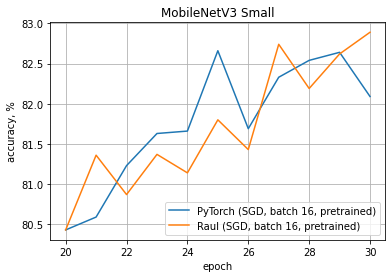

In [15]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
import matplotlib.pyplot as plt
%matplotlib inline


state = torch.load("checkpoint_30")
pytorch_acc_history = state["acc_history"]

pytorch_16_sgd_acc_history = [80.43] + acc_history_16
raul_16_sgd_acc_history= [
80.43,
81.36,
80.87,
81.37,
81.14,
81.80,
81.43,
82.74,
82.19,
82.62,
82.89
]

plt.title('MobileNetV3 Small')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
# plt.plot(range(15,31),pytorch_acc_history[15:31], '--', label="PyTorch (Adam, batch 50, original)")
plt.plot(range(20,31),pytorch_16_sgd_acc_history, label="PyTorch (SGD, batch 16, pretrained)")
plt.plot(range(20,31),raul_16_sgd_acc_history, label="Raul (SGD, batch 16, pretrained)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_sgd_16_acc.png")

In [16]:
acc_history_32=acc_history

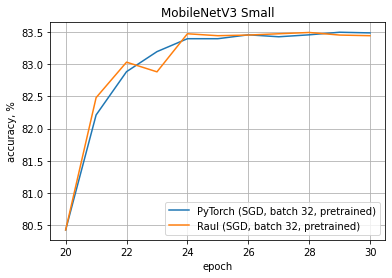

In [17]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
import matplotlib.pyplot as plt
%matplotlib inline


state = torch.load("checkpoint_30")
pytorch_acc_history = state["acc_history"]

pytorch_32_sgd_acc_history = [80.43] + acc_history_32
raul_32_sgd_acc_history= [
    80.43,
82.48,
83.03,
82.88,
83.47,
83.44,
83.45,
83.47,
83.49,
83.45,
83.44
]

plt.title('MobileNetV3 Small')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
# plt.plot(range(15,31),pytorch_acc_history[15:31], '--', label="PyTorch (Adam, batch 50, original)")
plt.plot(range(20,31),pytorch_32_sgd_acc_history, label="PyTorch (SGD, batch 32, pretrained)")
plt.plot(range(20,31),raul_32_sgd_acc_history, label="Raul (SGD, batch 32, pretrained)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_sgd_32_acc.png")

In [19]:
acc_history_64=acc_history

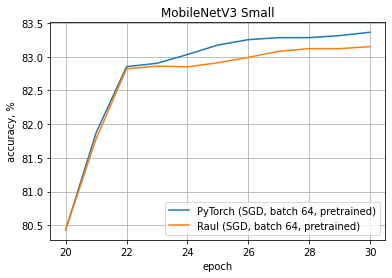

In [20]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
import matplotlib.pyplot as plt
%matplotlib inline


state = torch.load("checkpoint_30")
pytorch_acc_history = state["acc_history"]

pytorch_64_sgd_acc_history = [80.43] + acc_history_64
raul_64_sgd_acc_history= [
    80.43,
81.78,
82.82,
82.86,
82.85,
82.91,
82.99,
83.08,
83.12,
83.12,
83.15,
]

plt.title('MobileNetV3 Small')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
# plt.plot(range(15,31),pytorch_acc_history[15:31], '--', label="PyTorch (Adam, batch 50, original)")
plt.plot(range(20,31),pytorch_64_sgd_acc_history, label="PyTorch (SGD, batch 64, pretrained)")
plt.plot(range(20,31),raul_64_sgd_acc_history, label="Raul (SGD, batch 64, pretrained)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_sgd_64_acc.png")

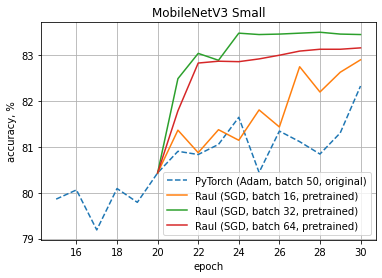

In [21]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
import matplotlib.pyplot as plt
%matplotlib inline


state = torch.load("checkpoint_30")
pytorch_acc_history = state["acc_history"]

pytorch_50_sgd_acc_history = [80.43] + pytorch_acc_history
raul_16_sgd_acc_history= [
80.43,
81.36,
80.87,
81.37,
81.14,
81.80,
81.43,
82.74,
82.19,
82.62,
82.89
]

raul_32_sgd_acc_history= [
    80.43,
82.48,
83.03,
82.88,
83.47,
83.44,
83.45,
83.47,
83.49,
83.45,
83.44
]

raul_64_sgd_acc_history= [
    80.43,
81.78,
82.82,
82.86,
82.85,
82.91,
82.99,
83.08,
83.12,
83.12,
83.15,
]

plt.title('MobileNetV3 Small')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
plt.plot(range(15,31),pytorch_acc_history[15:31], '--', label="PyTorch (Adam, batch 50, original)")
plt.plot(range(20,31),raul_16_sgd_acc_history, label="Raul (SGD, batch 16, pretrained)")
plt.plot(range(20,31),raul_32_sgd_acc_history, label="Raul (SGD, batch 32, pretrained)")
plt.plot(range(20,31),raul_64_sgd_acc_history, label="Raul (SGD, batch 64, pretrained)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_sgd_acc.png")

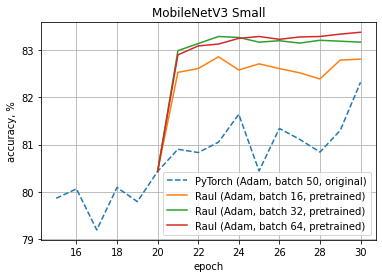

In [11]:
import torch
from pyraul.tools.dumping import dump_weights, DumpMode
import matplotlib.pyplot as plt
%matplotlib inline


state = torch.load("checkpoint_30")
pytorch_acc_history = state["acc_history"]

pytorch_50_sgd_acc_history = [80.43] + pytorch_acc_history
raul_16_adam_acc_history= [
80.43,
82.53,
82.61,
82.86,
82.58,
82.71,
82.61,
82.52,
82.39,
82.79,
82.81
]

raul_32_adam_acc_history= [
80.43,
82.99,
83.14,
83.29,
83.27,
83.17,
83.20,
83.15,
83.21,
83.19,
83.17
]

raul_64_adam_acc_history= [
80.43,
82.90,
83.09,
83.13,
83.25,
83.29,
83.23,
83.28,
83.29,
83.34,
83.38
]

plt.title('MobileNetV3 Small')
plt.grid(True)
plt.ylabel('accuracy, %')
plt.xlabel('epoch')
plt.plot(range(15,31),pytorch_acc_history[15:31], '--', label="PyTorch (Adam, batch 50, original)")
plt.plot(range(20,31),raul_16_adam_acc_history, label="Raul (Adam, batch 16, pretrained)")
plt.plot(range(20,31),raul_32_adam_acc_history, label="Raul (Adam, batch 32, pretrained)")
plt.plot(range(20,31),raul_64_adam_acc_history, label="Raul (Adam, batch 64, pretrained)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_adam_acc.png")

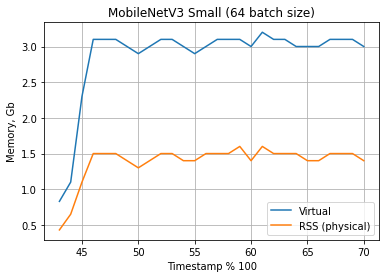

In [33]:
rss_time_64 = [
    (1587462343,   0.43),
(1587462344,   0.65),
(1587462345,   1.1),
(1587462346,   1.5),
(1587462347,   1.5),
(1587462348,   1.5),
(1587462349,   1.4),
(1587462350,   1.3),
(1587462351,   1.4),
(1587462352,   1.5),
(1587462353,   1.5),
(1587462354,   1.4),
(1587462355,   1.4),
(1587462356,   1.5),
(1587462357,   1.5),
(1587462358,   1.5),
(1587462359,   1.6),
(1587462360,   1.4),
(1587462361,   1.6),
(1587462362,   1.5),
(1587462363,   1.5),
(1587462364,   1.5),
(1587462365,   1.4),
(1587462366,   1.4),
(1587462367,   1.5),
(1587462368,   1.5),
(1587462369,   1.5),
(1587462370,   1.4)
]

virt_time_64 = [
(1587462343,   0.83),
(1587462344,   1.1 ),
(1587462345,   2.3 ),
(1587462346,   3.1 ),
(1587462347,   3.1 ),
(1587462348,   3.1 ),
(1587462349,   3.0 ),
(1587462350,   2.9 ),
(1587462351,   3.0 ),
(1587462352,   3.1 ),
(1587462353,   3.1 ),
(1587462354,   3.0 ),
(1587462355,   2.9 ),
(1587462356,   3.0 ),
(1587462357,   3.1 ),
(1587462358,   3.1 ),
(1587462359,   3.1 ),
(1587462360,   3.0 ),
(1587462361,   3.2 ),
(1587462362,   3.1 ),
(1587462363,   3.1 ),
(1587462364,   3.0 ),
(1587462365,   3.0 ),
(1587462366,   3.0 ),
(1587462367,   3.1 ),
(1587462368,   3.1 ),
(1587462369,   3.1 ),
(1587462370,   3.0 )
]

plt.title('MobileNetV3 Small (64 batch size)')
plt.grid(True)
plt.ylabel('Memory, Gb')
plt.xlabel('Timestamp % 100')
plt.plot([x[0]%100 for x in virt_time_64], [x[1] for x in virt_time_64], label="Virtual")
plt.plot([x[0]%100 for x in rss_time_64], [x[1] for x in rss_time_64], label="RSS (physical)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_64_ts.png")

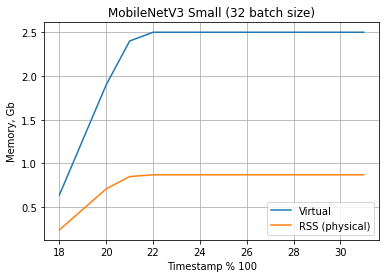

In [34]:
rss_time_32 = [
(1587463018,  0.24),
(1587463020, 0.71),
(1587463021, 0.85),
(1587463022, 0.87),
(1587463023, 0.87),
(1587463024, 0.87),
(1587463025, 0.87),
(1587463026, 0.87),
(1587463027, 0.87),
(1587463028, 0.87),
(1587463029, 0.87),
(1587463030, 0.87),
(1587463031, 0.87)
]

virt_time_32 = [
(1587463018,   0.64  ),
(1587463020,   1.9  ),
(1587463021,   2.4  ),
(1587463022,   2.5  ),
(1587463023,   2.5  ),
(1587463024,   2.5  ),
(1587463025,   2.5  ),
(1587463026,   2.5  ),
(1587463027,   2.5  ),
(1587463028,   2.5  ),
(1587463029,   2.5  ),
(1587463030,   2.5  ),
(1587463031,   2.5  )
]

plt.title('MobileNetV3 Small (32 batch size)')
plt.grid(True)
plt.ylabel('Memory, Gb')
plt.xlabel('Timestamp % 100')
plt.plot([x[0]%100 for x in virt_time_32], [x[1] for x in virt_time_32], label="Virtual")
plt.plot([x[0]%100 for x in rss_time_32], [x[1] for x in rss_time_32], label="RSS (physical)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_32_ts.png")

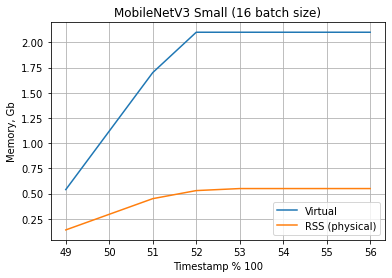

In [35]:
rss_time_16 = [
(1587463449, 0.14),
(1587463451, 0.45),
(1587463452, 0.53),
(1587463453, 0.55),
(1587463454, 0.55),
(1587463455, 0.55),
(1587463456, 0.55)
]

virt_time_16 = [
(1587463449,   0.54),
(1587463451,   1.7 ),
(1587463452,   2.1 ),
(1587463453,   2.1 ),
(1587463454,   2.1 ),
(1587463455,   2.1 ),
(1587463456,   2.1 )
]


plt.title('MobileNetV3 Small (16 batch size)')
plt.grid(True)
plt.ylabel('Memory, Gb')
plt.xlabel('Timestamp % 100')
plt.plot([x[0]%100 for x in virt_time_16], [x[1] for x in virt_time_16], label="Virtual")
plt.plot([x[0]%100 for x in rss_time_16], [x[1] for x in rss_time_16], label="RSS (physical)")
plt.legend(loc='lower right')
plt.savefig("mobilenetv3_small_16_ts.png")

## ONNX + Protobuf

#### ONNX

In [14]:
from pyraul.tools.seed import set_seed

config = {
    "seed": 0,
    "classes": 10,
    "bias": True,
    "batch_size": 50,
    "device": "cuda",
    "image_size": 224,
    "in_channels": 3,
#     "device": "cpu",
    "sgd": {"lr": 0.05}
}

set_seed(config["seed"])

device = torch.device(config["device"])
model = Classifier(ClassifierType.Small, num_classes=config["classes"], bias=config["bias"])
model = model.to(device)

import torch
from pyraul.tools.dumping import dump_weights, DumpMode
state = torch.load("/home/ck/archive/mobilenetv3/checkpoint_20")
model.load_state_dict(state["model_state_dict"])

tensor_in = torch.ones(config["batch_size"],  config["in_channels"], config["image_size"], config["image_size"]).to(device)
torch.onnx.export(model, tensor_in, "mobilenetv3_small.onnx",export_params=True, verbose=True, training=True)

graph(%input.1 : Float(50, 3, 224, 224),
      %mobilenetv3.conv1.weight : Float(16, 3, 3, 3),
      %mobilenetv3.conv1.bias : Float(16),
      %mobilenetv3.bn1.weight : Float(16),
      %mobilenetv3.bn1.bias : Float(16),
      %mobilenetv3.bn1.running_mean : Float(16),
      %mobilenetv3.bn1.running_var : Float(16),
      %mobilenetv3.bn1.num_batches_tracked : Long(),
      %mobilenetv3.bneck.0.se.se.1.weight : Float(4, 16, 1, 1),
      %mobilenetv3.bneck.0.se.se.1.bias : Float(4),
      %mobilenetv3.bneck.0.se.se.2.weight : Float(4),
      %mobilenetv3.bneck.0.se.se.2.bias : Float(4),
      %mobilenetv3.bneck.0.se.se.2.running_mean : Float(4),
      %mobilenetv3.bneck.0.se.se.2.running_var : Float(4),
      %mobilenetv3.bneck.0.se.se.2.num_batches_tracked : Long(),
      %mobilenetv3.bneck.0.se.se.4.weight : Float(16, 4, 1, 1),
      %mobilenetv3.bneck.0.se.se.4.bias : Float(16),
      %mobilenetv3.bneck.0.se.se.5.weight : Float(16),
      %mobilenetv3.bneck.0.se.se.5.bias : Float(16

#### Config (protobuf)

In [1]:
!protoc ./pyraul/tools/proto/raul_cfg.proto --python_out=.

In [2]:
!ls ./pyraul/tools/proto/

__pycache__  raul_cfg_pb2.py  raul_cfg.proto


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
print(optimizer)

In [4]:
from pyraul.tools.proto import raul_cfg_pb2
from google.protobuf import text_format

resize_step = raul_cfg_pb2.PreprocessingStep()
resize_step.type = raul_cfg_pb2.PreprocessingOperation.RESIZE
resize_step.options["size"] = 224.0

config = raul_cfg_pb2.TrainConfig()
config.name = "mobilenetv3_small"
config.bias = True
config.batch_size = 50
config.dataset = "CIFAR10"
config.optimizer = raul_cfg_pb2.Optimizer.ADAM
config.adam.lr = 0.001
config.adam.beta_1 = 0.9
config.adam.beta_2 = 0.999
config.adam.epsilon = 0.001
config.loss = raul_cfg_pb2.Loss.NEGATIVE_LOG_LIKELIHOOD
config.loss_reduction = raul_cfg_pb2.LossReduction.MEAN
config.preprocessing_pipeline.append(resize_step)
config.options["classes"] = 10

with open("raul_cfg_mobilenetv3.pbtxt", "w") as f:
    f.write(text_format.MessageToString(config))

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv